### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
import random
import pickle
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
%matplotlib inline
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)

###  Reading Data Sets

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

### Shape of Train and Test Data

In [3]:
df_train.shape, df_test.shape

((12980, 12), (4399, 11))

### Train Data

In [4]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


### Data Types

In [5]:
data_types = pd.DataFrame(df_train.dtypes, columns = ['Data Type'])
data_types

,Data Type
datetime,object
season,int64
holiday,int64
workingday,int64
weather,int64
temp,float64
atemp,float64
humidity,float64
windspeed,float64
casual,int64


### Missing Values in Train and Test Data

In [6]:
missing_values = pd.DataFrame(df_train.isna().sum(), columns = ['Missing Values'])
missing_values

,Missing Values
datetime,0
season,0
holiday,0
workingday,0
weather,0
temp,0
atemp,0
humidity,0
windspeed,0
casual,0


### Extracting Information from Datetime Column and Dropping It

In [7]:
df_train['yyyymmdd'] = df_train['datetime'].apply(lambda x : x.split()[0])
df_train['year'] = df_train['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').year)
df_train['month'] = df_train['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').month)
df_train['date'] = df_train['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').day)
df_train['hour'] = df_train['datetime'].apply(lambda x : x.split()[1].split(":")[0])
df_train = df_train.drop(['datetime', 'yyyymmdd'], axis = 1)

### Categorizing Date Column Into Week

In [8]:
week = []
for i in df_train['date']:
    if i < 8:
        week.append(1)
    elif i >= 8 and i < 16:
        week.append(2)
    elif i >=16 and i < 22:
        week.append(3)
    else:
        week.append(4)
df_train['week'] = week

### Converting Hour Column to Int Type

In [9]:
df_train['hour'] = df_train['hour'].astype('object').astype('int64')

### Columns

In [10]:
df_train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'date', 'hour', 'week'],
      dtype='object')

### Data Types

In [11]:
data_types = pd.DataFrame(df_train.dtypes, columns = ['Data Type'])
data_types

,Data Type
season,int64
holiday,int64
workingday,int64
weather,int64
temp,float64
atemp,float64
humidity,float64
windspeed,float64
casual,int64
registered,int64


### Train Data

In [12]:
df_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,date,hour,week
0,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16,2011,1,1,0,1
1,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40,2011,1,1,1,1
2,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32,2011,1,1,2,1
3,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13,2011,1,1,3,1
4,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1,2011,1,1,4,1


### Numerical Analysis of Train Data Continuous Variables

In [13]:
df_train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].describe()

,temp,atemp,humidity,windspeed,casual,registered,count
count,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000
mean,19.725422,23.112436,62.358552,13.141760,32.441757,135.136055,167.577812
std,7.828902,8.552046,19.963696,8.325987,46.636228,131.921431,160.758887
min,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.120000,15.910000,47.000000,7.001500,3.000000,30.000000,35.000000
50%,19.680000,23.485000,62.000000,12.998000,14.000000,103.000000,124.000000
75%,26.240000,30.305000,79.000000,19.001200,42.000000,194.000000,245.000000
max,40.180000,50.000000,100.000000,56.996900,367.000000,796.000000,957.000000


### Correlation Map

<AxesSubplot:>

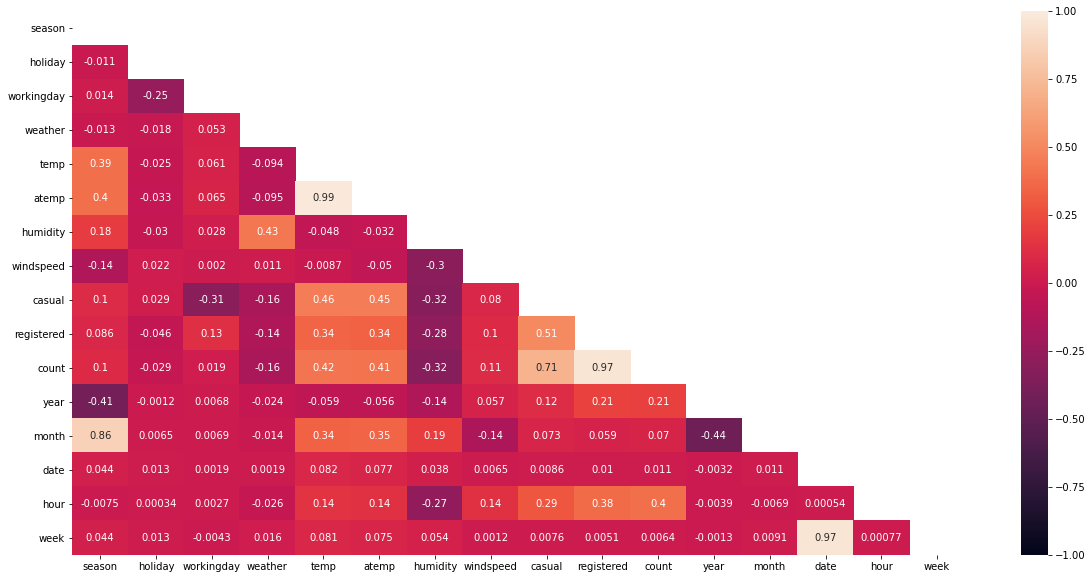

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(df_train.corr(), vmax = 1, vmin = -1, square = False, annot = True, mask = np.triu(df_train.corr()))

        Count is very highly positively related to registered and casual.

        Season is very highly positively related to month.

        Temperature is very highly positively related to actual temperature
        
        Date is very highly positively related to week as we have created week out of date column.

### Season

Text(0, 0.5, 'Count')

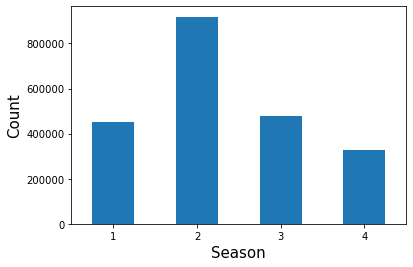

In [15]:
df_train.groupby('season')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Season', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        42% bookings are done in season 2.

        64% bookings are done in seasons 2 and 3.

### Holiday

Text(0, 0.5, 'Count')

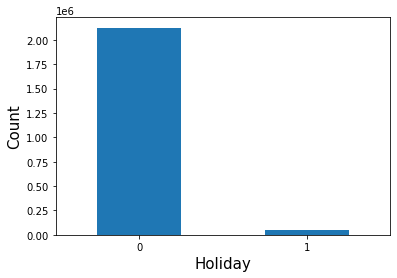

In [16]:
df_train.groupby('holiday')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Holiday', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        98% bookings are done on non-holidays.

### Working Day

Text(0, 0.5, 'Count')

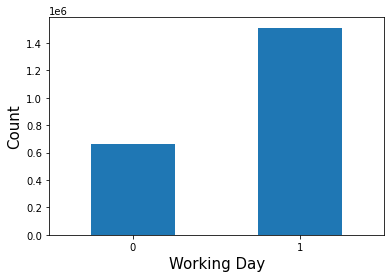

In [17]:
df_train.groupby('workingday')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Working Day', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        69% bookings are done on working days.

### Weather

Text(0, 0.5, 'Count')

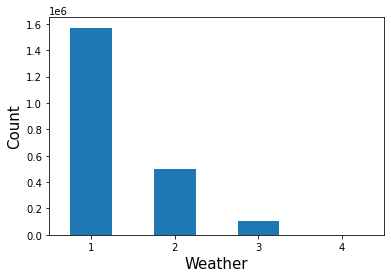

In [18]:
df_train.groupby('weather')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Weather', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        72% bookings are done in weather 1.

        95% bookings are done in weathers 1 and 2.

### Actual Temperature

Text(0, 0.5, 'Count')

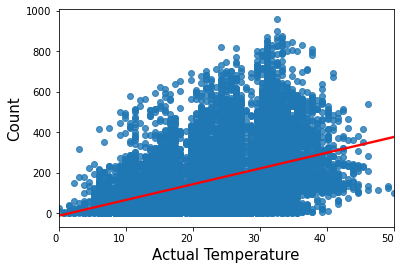

In [19]:
sns.regplot(x = df_train['atemp'], y = df_train['count'], line_kws = {'color': 'red'})
plt.xticks(fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Actual Temperature', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        Bookings are increasing with the increase in actual temperature.

Text(0.5, 1.0, 'Train Actual Temperature')

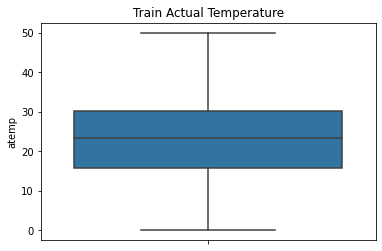

In [20]:
sns.boxplot(y = df_train['atemp'])
plt.title('Train Actual Temperature')

Text(0.5, 1.0, 'Train Actual Temperature')

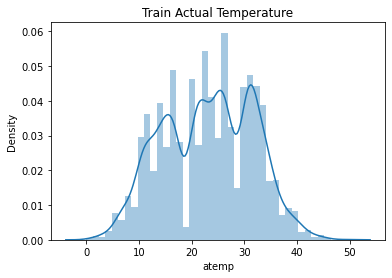

In [21]:
sns.distplot(df_train['atemp'])
plt.title('Train Actual Temperature')

### Humidity

Text(0, 0.5, 'Count')

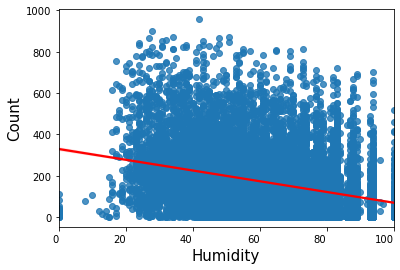

In [22]:
sns.regplot(x = df_train['humidity'], y = df_train['count'], line_kws = {'color': 'red'})
plt.xticks(fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Humidity', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        Bookings are decreasing with the increase in humidity.

Text(0.5, 1.0, 'Train Humidity')

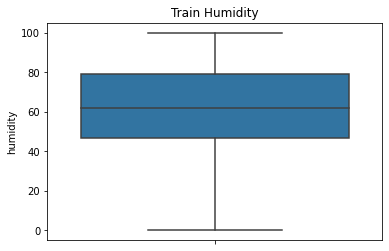

In [23]:
sns.boxplot(y = df_train['humidity'])
plt.title('Train Humidity')

Text(0.5, 1.0, 'Train Humidity')

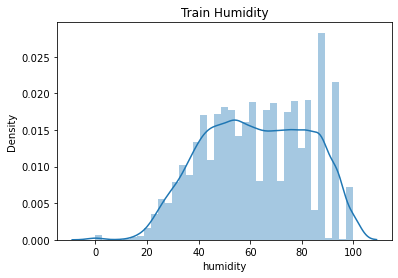

In [24]:
sns.distplot(df_train['humidity'])
plt.title('Train Humidity')

### Wind Speed

Text(0, 0.5, 'Count')

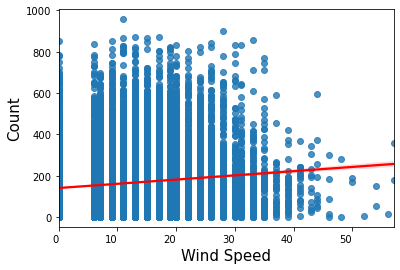

In [25]:
sns.regplot(x = df_train['windspeed'], y = df_train['count'], line_kws = {'color': 'red'})
plt.xticks(fontsize = 10, ha = "right")
plt.yticks(fontsize = 10)
plt.xlabel('Wind Speed', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        Bookings are slightly increasing with the increase in wind speed.

Text(0.5, 1.0, 'Train Wind Speed')

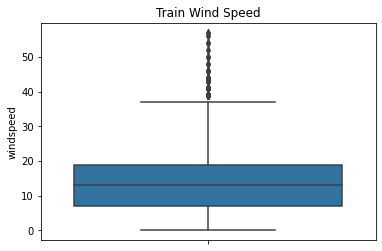

In [26]:
sns.boxplot(y = df_train['windspeed'])
plt.title('Train Wind Speed')

Text(0.5, 1.0, 'Train Wind Speed')

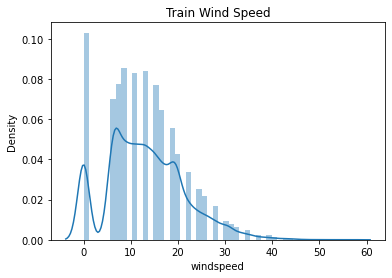

In [27]:
sns.distplot(df_train['windspeed'])
plt.title('Train Wind Speed')

### Transforming Wind Speed

Text(0.5, 1.0, 'Train Wind Speed')

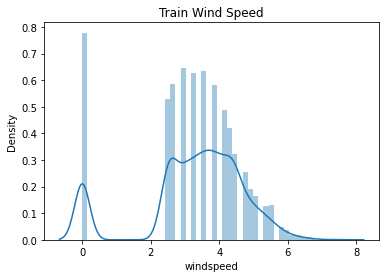

In [28]:
df_train['windspeed'] = df_train['windspeed'] ** (1/2)
sns.distplot(df_train['windspeed'])
plt.title('Train Wind Speed')

### Removing the Outliers in Wind Speed

In [29]:
wind_speed_train = []
for i in df_train['windspeed']:
    if i < (df_train['windspeed'].mean() - (2 * df_train['windspeed'].std())):
        wind_speed_train.append(df_train['windspeed'].mean() - (2 * df_train['windspeed'].std()))
    elif i > (df_train['windspeed'].mean() + (2 * df_train['windspeed'].std())):
        wind_speed_train.append(df_train['windspeed'].mean() + (2 * df_train['windspeed'].std()))
    else:
        wind_speed_train.append(i)
df_train['windspeed'] = wind_speed_train

### Year

Text(0, 0.5, 'Count')

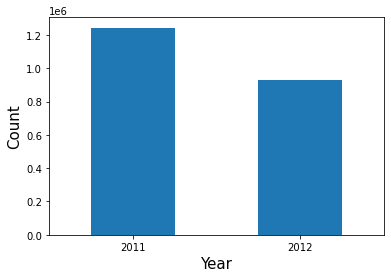

In [30]:
df_train.groupby('year')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        57% bookings are done in 2011.
        
        This data is not that valuable as we don't have the complete 2012 data with us. It is just upto June 2012.
        
        However we can compare the first six months of these two years.

Text(0, 0.5, 'Count')

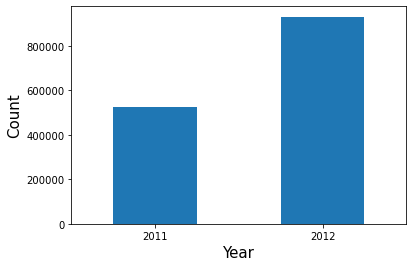

In [31]:
new_df = df_train[df_train['month'] < 7]
new_df.groupby('year')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        64% bookings are done in the first 6 months of 2012.

### Month

Text(0, 0.5, 'Count')

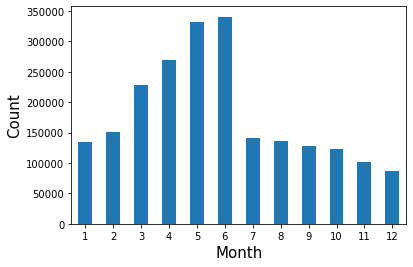

In [32]:
df_train.groupby('month')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Month', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        16% bookings are done in June.
        
        31% bookings are done in May and June.
        
        67% bookings are done during January to June.
        
        54% bookings are done during March to June.

### Week

Text(0, 0.5, 'Count')

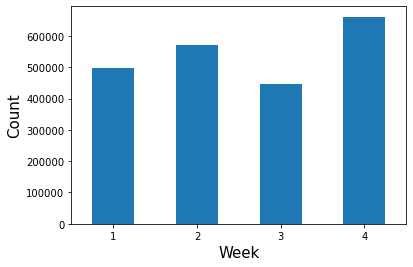

In [33]:
df_train.groupby('week')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Week', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        30% bookings are done in the last week of a month.
        
        51% bookings are done in second half of the month.

### Hour

Text(0, 0.5, 'Count')

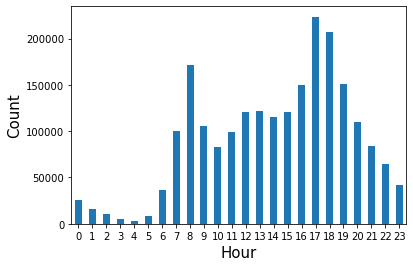

In [34]:
df_train.groupby('hour')['count'].sum().plot.bar()
plt.xticks(rotation = 0, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Hour', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

        55% bookings are done in between 12 noon to 8 pm.

        74% bookings are done in between 8 am to 8 pm.

### Count

Text(0.5, 1.0, 'Train Count')

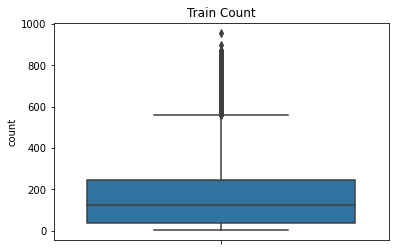

In [35]:
sns.boxplot(y = df_train['count'])
plt.title('Train Count')

Text(0.5, 1.0, 'Train Count')

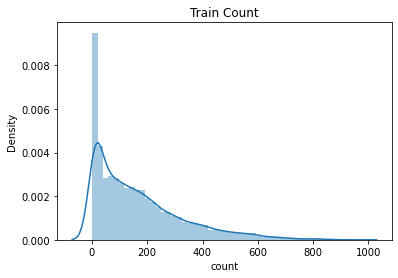

In [36]:
sns.distplot(df_train['count'])
plt.title('Train Count')

### Transforming Count

Text(0.5, 1.0, 'Train Count')

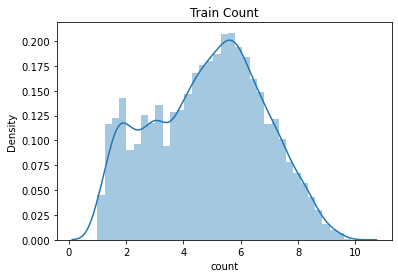

In [37]:
df_train['count'] = df_train['count'] ** (1/3)
sns.distplot(df_train['count'])
plt.title('Train Count')

### Removing Outliers in Count

In [38]:
count_train = []
for i in df_train['count']:
    if i < (df_train['windspeed'].mean() - (2 * df_train['windspeed'].std())):
        count_train.append(df_train['windspeed'].mean() - (2 * df_train['windspeed'].std()))
    elif i > (df_train['windspeed'].mean() + (2 * df_train['windspeed'].std())):
        count_train.append(df_train['windspeed'].mean() + (2 * df_train['windspeed'].std()))
    else:
        count_train.append(i)
df_train['count'] = count_train

### Dropping Unnecessary Columns

In [39]:
df_train = df_train.drop(['temp', 'casual', 'registered', 'date'], axis = 1)

### Scaling Data

In [40]:
df_train_scaled = pd.DataFrame(StandardScaler().fit_transform(df_train.drop('count', axis = 1)), columns = df_train.drop('count', axis = 1).columns)

### Scaled Train Data

In [41]:
df_train_scaled.head()

,season,holiday,workingday,weather,atemp,humidity,windspeed,year,month,hour,week
0,-1.150497,-0.168172,-1.478004,-0.658491,-1.019379,0.933803,-2.16784,-0.708128,-1.375573,-1.671741,-1.373838
1,-1.150497,-0.168172,-1.478004,-0.658491,-1.108250,0.883711,-2.16784,-0.708128,-1.375573,-1.527059,-1.373838
2,-1.150497,-0.168172,-1.478004,-0.658491,-1.108250,0.883711,-2.16784,-0.708128,-1.375573,-1.382376,-1.373838
3,-1.150497,-0.168172,-1.478004,-0.658491,-1.019379,0.633246,-2.16784,-0.708128,-1.375573,-1.237693,-1.373838
4,-1.150497,-0.168172,-1.478004,-0.658491,-1.019379,0.633246,-2.16784,-0.708128,-1.375573,-1.093011,-1.373838


### Feature Selection

In [42]:
etr = ExtraTreesRegressor()
etr.fit(df_train_scaled, df_train['count'])
fi = pd.DataFrame(etr.feature_importances_, columns = ['Importance'], index = df_train_scaled.columns)
fi.sort_values(by = 'Importance', ascending = False)

,Importance
hour,0.706220
atemp,0.078815
workingday,0.066394
humidity,0.033003
season,0.025125
year,0.024253
weather,0.022826
month,0.020602
windspeed,0.010905
week,0.009046


### Train - Validation Split

In [43]:
X = df_train_scaled[['hour', 'atemp', 'workingday', 'humidity', 'season']]
y = df_train['count']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 17)

### Shapes of the Data Sets

In [44]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((10384, 5), (2596, 5), (10384,), (2596,))

### LinearRegressor()

In [45]:
#lr = LinearRegression()
#lr.fit(X_train, y_train)
#y_train_pred = lr.predict(X_train)
#y_val_pred = lr.predict(X_val)

In [46]:
#print('Train R2 : ', r2_score(y_train, y_train_pred))
#print('Validation R2 : ', r2_score(y_val, y_val_pred))

In [47]:
#sns.distplot(y_val_pred - y_val)

### RandomForestRegressor()

In [48]:
#rfr = RandomForestRegressor()
#possible_parameter_values = {'n_estimators' : [int(x) for x in np.arange(start = 50, stop = 1001, step = 50)],
#                             'max_depth' : [int(x) for x in np.arange(start = 5, stop = 101, step = 5)],
#                             'min_samples_split' : [int(x) for x in np.arange(start = 5, stop = 101, step = 1)],
#                             'min_samples_leaf' : [int(x) for x in np.arange(start = 1, stop = 51, step = 1)]}
#rfr_rscv = RandomizedSearchCV(estimator = rfr, param_distributions = possible_parameter_values, cv = 10, scoring = 'neg_mean_squared_error', verbose = 2, random_state = 17, n_jobs = 1)
#rfr_rscv.fit(X_train, y_train)
#rfr_rscv.best_params_

In [49]:
#y_train_pred = rfr_rscv.predict(X_train)
#y_val_pred = rfr_rscv.predict(X_val)

In [50]:
#print('Train R2 : ', r2_score(y_train, y_train_pred))
#print('Validation R2 : ', r2_score(y_val, y_val_pred))

In [51]:
#sns.distplot(y_val_pred - y_val)

### KNeighborsRegressor()

In [52]:
#knr = KNeighborsRegressor()
#possible_parameter_values = {'n_neighbors' : [int(x) for x in np.arange(start = 1, stop = 101, step = 1)],
#                             'weights' : ['uniform', 'distance']}
#knr_rscv = RandomizedSearchCV(estimator = knr, param_distributions = possible_parameter_values, cv = 10, scoring = 'neg_mean_squared_error', verbose = 2, random_state = 17, n_jobs = 1)
#knr_rscv.fit(X_train, y_train)
#knr_rscv.best_params_

In [53]:
#y_train_pred = knr_rscv.predict(X_train)
#y_val_pred = knr_rscv.predict(X_val)

In [54]:
#print('Train R2 : ', r2_score(y_train, y_train_pred))
#print('Validation R2 : ', r2_score(y_val, y_val_pred))

In [55]:
#sns.distplot(y_val_pred - y_val)

### SVR()

In [56]:
#svr = SVR()
#possible_parameter_values = {'gamma' : [float(x)/10000 for x in np.arange(start = 1, stop = 100000, step = 1)],
#                             'C' : [float(x)/10 for x in np.arange(start = 1, stop = 101, step = 1)]}
#svr_rscv = RandomizedSearchCV(estimator = svr, param_distributions = possible_parameter_values, cv = 10, scoring = 'neg_mean_squared_error', verbose = 2, random_state = 17, n_jobs = 1)
#svr_rscv.fit(X_train, y_train)
#svr_rscv.best_params_

In [57]:
#y_train_pred = svr_rscv.predict(X_train)
#y_val_pred = svr_rscv.predict(X_val)

In [58]:
#print('Train R2 : ', r2_score(y_train, y_train_pred))
#print('Validation R2 : ', r2_score(y_val, y_val_pred))

In [59]:
#sns.distplot(y_val_pred - y_val)

        So RandomForestRegressor() is the best algorithm to build the model

### Evaluating the Consistency of the Model

In [60]:
X = df_train_scaled[['hour', 'atemp', 'workingday', 'humidity', 'season']]
y = df_train['count']
r2_train = []
r2_val = []
rmsle = []
for i in range(0,10):
    rs = random.randint(0, 100)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = rs)
    test_model = RandomForestRegressor(n_estimators = 500, min_samples_split = 26, min_samples_leaf = 5, max_depth = 45)
    test_model.fit(X_train, y_train)
    y_train_pred = test_model.predict(X_train)
    y_val_pred = test_model.predict(X_val)
    r2_train.append(r2_score(y_train, y_train_pred))
    r2_val.append(r2_score(y_val, y_val_pred))
    rmsle.append(np.sqrt(mean_squared_log_error(y_val, y_val_pred)))
data = {'Train R2' : r2_train, 'Validation R2' : r2_val}
data = pd.DataFrame(data)
data['Difference'] = ((np.abs(data['Train R2'] - data['Validation R2'])) * 100)/(data['Train R2'])
data['RMSLE'] = rmsle
data

,Train R2,Validation R2,Difference,RMSLE
0,0.922652,0.899740,2.483319,0.103584
1,0.922066,0.902447,2.127779,0.105369
2,0.922658,0.902393,2.196367,0.103734
3,0.922646,0.901760,2.263743,0.104103
4,0.922485,0.899834,2.455489,0.105878
5,0.922932,0.902648,2.197711,0.106849
6,0.922718,0.902436,2.198026,0.103731
7,0.922311,0.904332,1.949342,0.100612
8,0.922174,0.903359,2.040258,0.104668
9,0.922009,0.903967,1.956806,0.107233


        Model seems to be consistent.

### Test Data Preprocessing

In [61]:
df_test['yyyymmdd'] = df_test['datetime'].apply(lambda x : x.split()[0])
df_test['year'] = df_test['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').year)
df_test['month'] = df_test['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').month)
df_test['date'] = df_test['yyyymmdd'].apply(lambda dateString : datetime.strptime(dateString,'%Y-%m-%d').day)
df_test['hour'] = df_test['datetime'].apply(lambda x : x.split()[1].split(":")[0])
df_test = df_test.drop(['datetime', 'yyyymmdd'], axis = 1)
week = []
for i in df_test['date']:
    if i < 8:
        week.append(1)
    elif i >= 8 and i < 16:
        week.append(2)
    elif i >=16 and i < 22:
        week.append(3)
    else:
        week.append(4)
df_test['week'] = week
df_test['hour'] = df_test['hour'].astype('object').astype('int64')
df_test['windspeed'] = df_test['windspeed'] ** (1/2)
wind_speed_test = []
for i in df_test['windspeed']:
    if i < (df_test['windspeed'].mean() - (2 * df_test['windspeed'].std())):
        wind_speed_test.append(df_test['windspeed'].mean() - (2 * df_test['windspeed'].std()))
    elif i > (df_test['windspeed'].mean() + (2 * df_test['windspeed'].std())):
        wind_speed_test.append(df_test['windspeed'].mean() + (2 * df_test['windspeed'].std()))
    else:
        wind_speed_test.append(i)
df_test['windspeed'] = wind_speed_test
df_test = df_test.drop(['temp', 'casual', 'registered', 'date'], axis = 1)
df_test_scaled = pd.DataFrame(StandardScaler().fit_transform(df_test), columns = df_test.columns)
X_test = df_test_scaled[['hour', 'atemp', 'workingday', 'humidity', 'season']]

In [62]:
X_test.head()

,hour,atemp,workingday,humidity,season
0,-1.520424,0.357851,-1.43496,1.472355,-0.466962
1,-1.375948,0.357851,-1.43496,1.472355,-0.466962
2,-1.231473,0.357851,-1.43496,1.472355,-0.466962
3,-1.086998,0.177476,-1.43496,1.764464,-0.466962
4,-0.942522,0.357851,-1.43496,1.472355,-0.466962


### Final Prediction

In [63]:
prediction = test_model.predict(X_test)
prediction

array([4.36973014, 3.8441167 , 3.00694684, ..., 3.76318251, 3.63457382,
       2.96534601])

### Exporting Predictions to CSV

In [64]:
prediction = pd.DataFrame((prediction) ** 3, columns = ['Predicted Counts'])
prediction = prediction.round(decimals = 0)
prediction['Predicted Counts'] = prediction['Predicted Counts'].astype('float').astype(int)
prediction.to_csv('Prediction.csv')

### Pickle

In [67]:
file = open(r'C:\\Users\\Brajesh Mohapatra\\Python\\Bike Count Prediction\\bike_count_prediction.pkl', 'wb')
pickle.dump(test_model, file)